In [2]:
import geopandas as gpd
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [172]:
# Load data and clean column names
ward_airbnb = gpd.read_file("data/ward_airbnb.gpkg")
boroughs = gpd.read_file("data/statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp")

In [177]:
# Calculate the 95th quantile for Airbnb density
quantile = np.quantile(ward_airbnb['airbnb_per_1000_household'], 0.95)
print(f"95th quantile: {quantile}")

# Create a high Airbnb density indicator
ward_airbnb['high_airbnb_dens'] = ward_airbnb['airbnb_per_1000_household'] >= quantile

95th quantile: 5.628932432591062


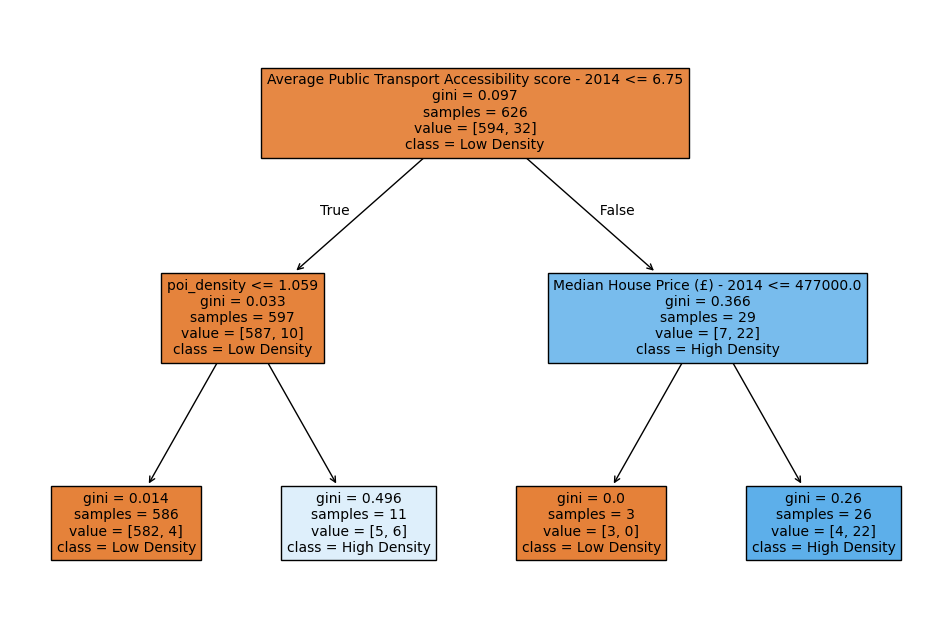

In [178]:
# Prepare data for the decision tree
X = ward_airbnb[['poi_density', 
                 'Average Public Transport Accessibility score - 2014', 
                 'Median House Price (£) - 2014', 
                 'Median Household income estimate (2012/13)']]  # Handle missing values
y = ward_airbnb['high_airbnb_dens']

# Train a decision tree
tree = DecisionTreeClassifier(max_depth=2, random_state=42)
tree.fit(X, y)

# Plot the decision tree
plt.figure(figsize=(12, 8))
plot_tree(tree, feature_names=X.columns, class_names=['Low Density', 'High Density'], filled=True, fontsize=10)
plt.show()

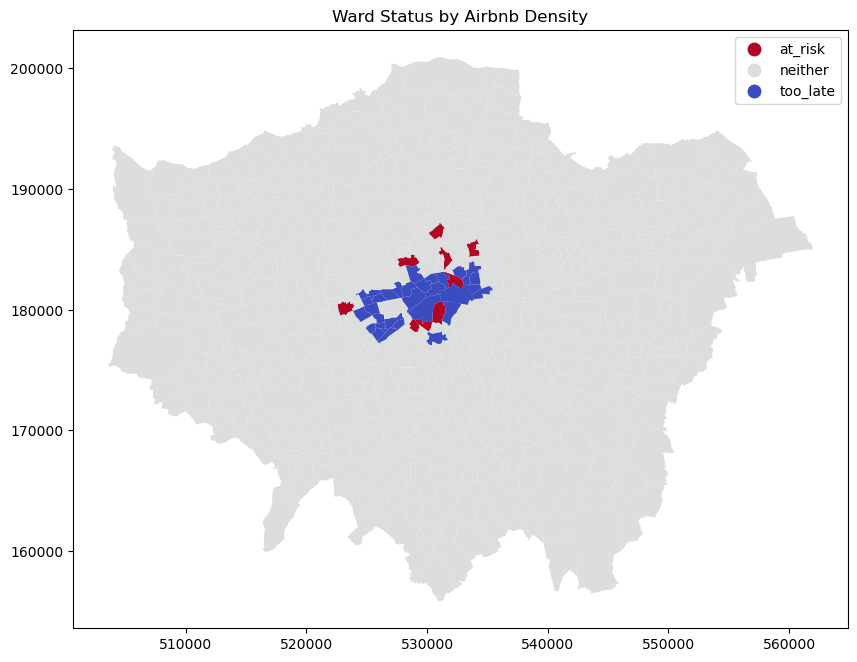

In [179]:
# Add predictions to the GeoDataFrame
ward_airbnb['prediction'] = tree.predict_proba(X)[:, 1] > 0.5

# Generate the at-risk and too-late categories
at_risk = ward_airbnb[(ward_airbnb['high_airbnb_dens'] == False) & (ward_airbnb['prediction'] == True)]
too_late = ward_airbnb[ward_airbnb['high_airbnb_dens'] == True]

ward_airbnb['status'] = 'neither'
ward_airbnb.loc[ward_airbnb['Ward name'].isin(too_late['Ward name']), 'status'] = 'too_late'
ward_airbnb.loc[ward_airbnb['Ward name'].isin(at_risk['Ward name']), 'status'] = 'at_risk'

# Visualise with a choropleth map
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ward_airbnb.plot(column='status', 
                 legend=True, 
                 cmap='coolwarm_r', 
                 ax=ax, 
                 legend_kwds={'bbox_to_anchor': (1, 1)})
plt.title("Ward Status by Airbnb Density")
plt.show()

In [180]:
at_risk[['Ward name']]

,Ward name
225,Lambeth - Bishop's
454,Hammersmith and Fulham - Shepherd's Bush Green
483,Westminster - Vincent Square
492,Westminster - Warwick
504,Camden - Camden Town with Primrose Hill
535,Islington - St. Mary's
540,Islington - Bunhill
546,Islington - Finsbury Park
554,Hackney - Dalston


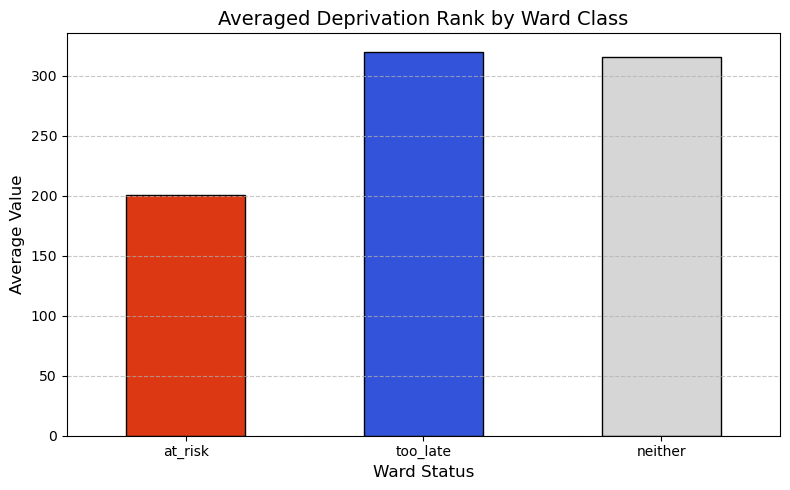

In [181]:
## Bar plot

# List of variables to analyze
variables = [
    '(ID2010) - Rank of average score (within London) - 2010'#,
    #'(ID2010) % of LSOAs in worst 50% nationally - 2010',
    #'Median Household income estimate (2012/13)',
    #'Average GCSE capped point scores - 2014',
    #'% BAME - 2011'
]

# Custom order for the categories
category_order = ['at_risk', 'too_late', 'neither']

# Group the data by 'status' and calculate medians
#averages = ward_airbnb.groupby('status')[variables].median()
averages = ward_airbnb.groupby('status')[variables].mean()

# Reindex to ensure the correct order of categories
averages = averages.reindex(category_order)

# Create individual bar plots for each variable
for var in variables:
    plt.figure(figsize=(8, 5))
    averages[var].plot(kind='bar', color=['#dd3814', '#3354da', '#d6d6d6'], edgecolor='black')

    # Customize the plot
    plt.title(f'Averaged Deprivation Rank by Ward Class', fontsize=14)
    plt.ylabel('Average Value', fontsize=12)
    plt.xlabel('Ward Status', fontsize=12)
    plt.xticks(rotation=0, fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Show the plot
    plt.tight_layout()
    plt.show()

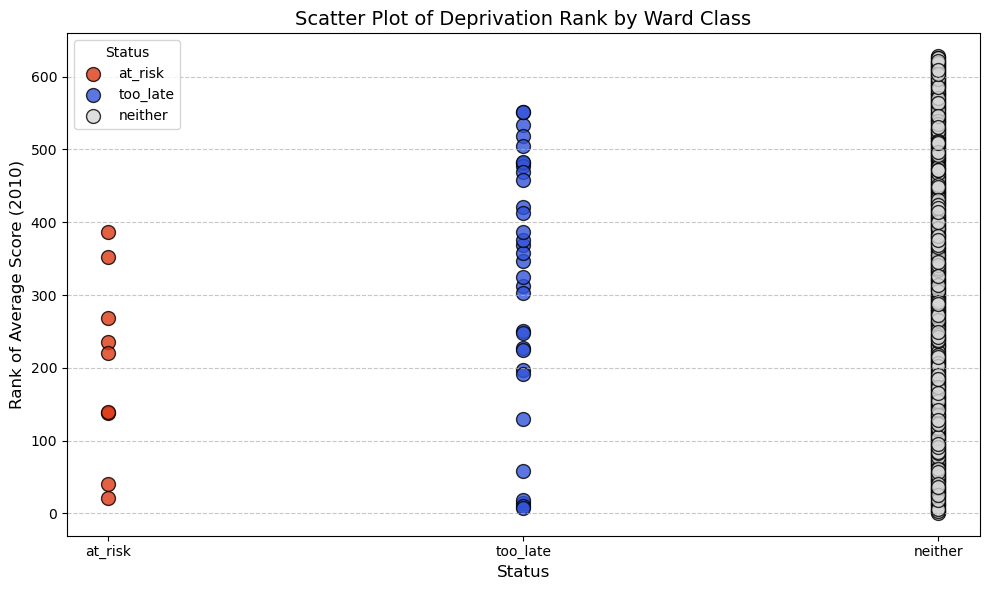

In [182]:
## Scatter plot
plt.figure(figsize=(10, 6))
    
colors = ['#dd3814', '#3354da', '#d6d6d6']  # Adjust as needed
statuses = ['at_risk', 'too_late', 'neither']  # Define custom order for statuses

# Loop through each status and plot points
for color, status in zip(colors, statuses):
    subset = ward_airbnb[ward_airbnb['status'] == status]
    plt.scatter(
            x=[status] * len(subset),  # Use the status as the x-coordinate
            y=subset['(ID2010) - Rank of average score (within London) - 2010'],
            label=status,
            color=color,
            edgecolor='black',
            alpha=0.8,
            s=100  # Size of points
        )

# Customize the plot
plt.title('Scatter Plot of Deprivation Rank by Ward Class', fontsize=14)
plt.xlabel('Status', fontsize=12)
plt.ylabel('Rank of Average Score (2010)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Status', loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()


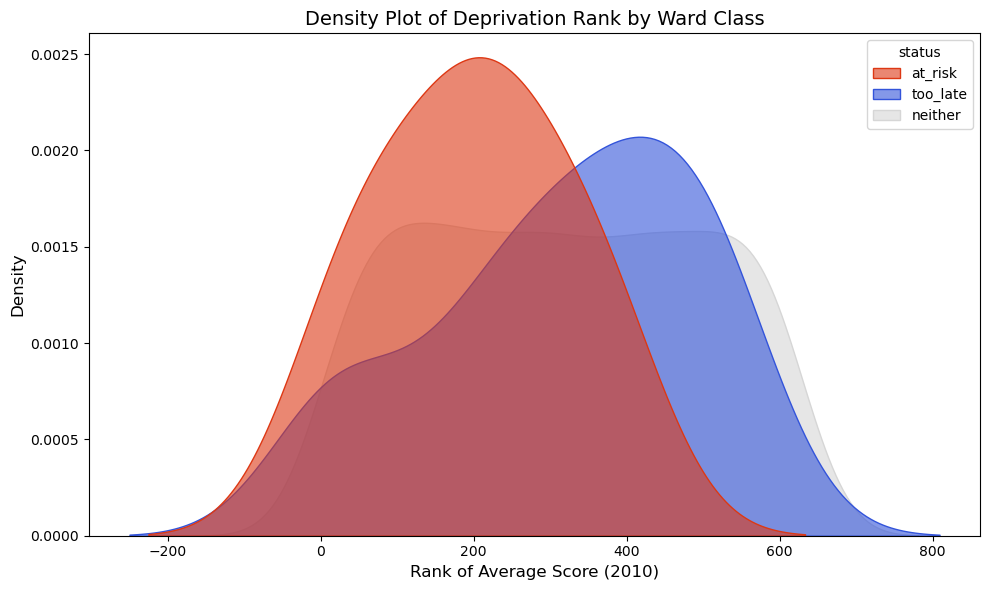

In [183]:
## Scatter plot

import seaborn as sns

# Reorder the statuses
status_order = ['at_risk', 'too_late', 'neither']

plt.figure(figsize=(10, 6))

# Create density plot for each status with the same scale
sns.kdeplot(data=ward_airbnb, 
            x='(ID2010) - Rank of average score (within London) - 2010', 
            hue='status', 
            hue_order=status_order,  # Set the custom order for statuses
            fill=True, 
            common_norm=False,  # Normalize each density individually
            palette=['#dd3814', '#3354da', '#d6d6d6'],  # Custom color palette
            alpha=0.6)  # Transparency for the fill

# Customize the plot
plt.title('Density Plot of Deprivation Rank by Ward Class', fontsize=14)
plt.xlabel('Rank of Average Score (2010)', fontsize=12)
plt.ylabel('Density', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

In [184]:
##Chi^2 (not significant)

# Filter dataset to include only 'at_risk' and 'too_late' categories (excluding 'neither')
ward_airbnb_filtered = ward_airbnb[ward_airbnb['status'].isin(['at_risk', 'too_late'])]

# Create a contingency table between 'status' and 'deprivation_category'
contingency_table = pd.crosstab(ward_airbnb_filtered['status'], ward_airbnb['(ID2010) - Rank of average score (within London) - 2010'])

# Perform chi-square test
chi2_stat, p_val, dof, expected = stats.chi2_contingency(contingency_table)

# Print results
print(f"Chi-square Statistic: {chi2_stat}")
print(f"P-value: {p_val}")
print(f"Degrees of Freedom: {dof}")

Chi-square Statistic: 41.0
P-value: 0.382868189120542
Degrees of Freedom: 39


/tmp/ipykernel_666/1963392027.py:11: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(ward_airbnb)


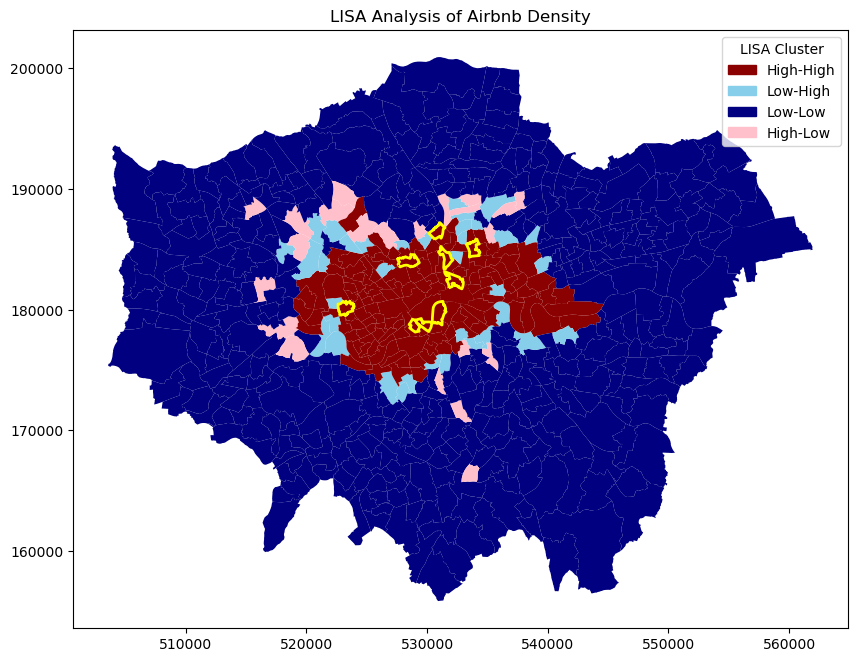

In [185]:
## LISA Analysis: Airbnb Density

import matplotlib.pyplot as plt
import geopandas as gpd
from libpysal.weights import Queen
from esda import Moran_Local
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap

# Generate spatial weights matrix using Queen contiguity
w = Queen.from_dataframe(ward_airbnb)

# Ensure the weights are row-standardized
w.transform = 'r'

# Use the vulnerability variable for LISA analysis
y = ward_airbnb['airbnb_per_1000_household'].values

# Calculate Local Moran's I
lisa = Moran_Local(y, w)

# Add LISA statistics to the GeoDataFrame
ward_airbnb['moran_local'] = lisa.Is
ward_airbnb['p_value'] = lisa.p_sim
ward_airbnb['quadrant'] = lisa.q

# Identify significant clusters at 0.05 level
ward_airbnb['significant'] = ward_airbnb['p_value'] < 0.05

# Define custom colormap for the LISA quadrants
custom_cmap = ListedColormap(['darkred', 'skyblue', 'navy', 'pink'])  # Soft dark red, soft light blue, soft dark blue, soft light red

# Plot the LISA results
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Use 'quadrant' for the categorical color mapping
ward_airbnb.plot(
    column='quadrant',  # Use 'quadrant' for discrete categories
    cmap=custom_cmap,    # Apply the custom colormap
    ax=ax,
    legend=False         # Disable the color bar
)

# Outline the wards with 'at_risk' status
at_risk_wards = inner_london_wards[inner_london_wards['status'] == 'at_risk']
at_risk_wards.plot(
    edgecolor='yellow',    # Set black boundary for at-risk wards
    linewidth=2,          # Thicker line width for visibility
    ax=ax,
    facecolor='none'      # No fill color, just outlines
)

# Manually create legend with cluster labels
legend_labels = ['High-High', 'Low-High', 'Low-Low', 'High-Low']
colors = custom_cmap(range(4))  # Get colors from the custom colormap

# Add the custom legend to the plot
legend_elements = [Patch(color=colors[i], label=legend_labels[i]) for i in range(4)]
ax.legend(handles=legend_elements, title='LISA Cluster')

plt.title('LISA Analysis of Airbnb Density')
plt.show()

/opt/conda/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


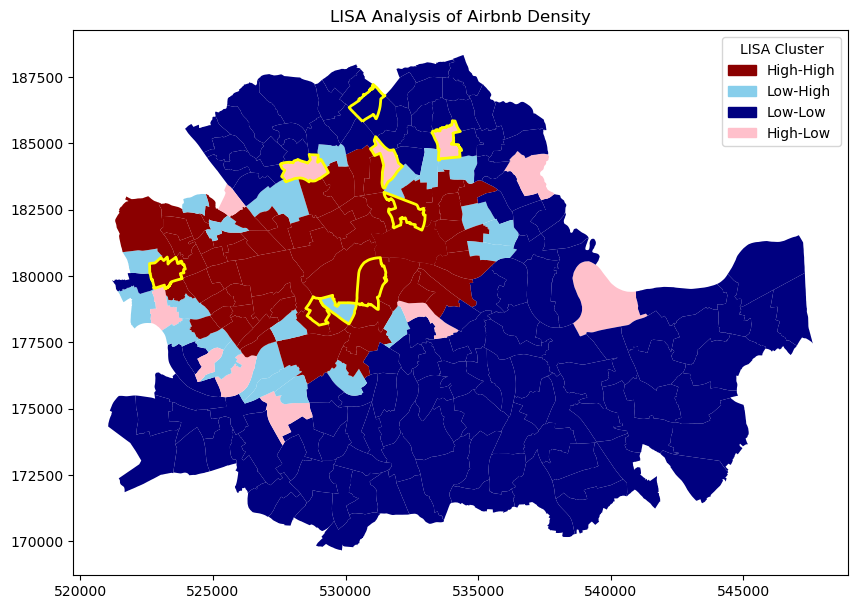

In [144]:
## Inner London LISA Analysis: Density

# List of Inner London Boroughs
inner_london_boroughs = [
    'Camden', 'Greenwich', 'Hackney', 'Hammersmith and Fulham', 'Islington', 
    'Kensington and Chelsea', 'Lambeth', 'Lewisham', 'Southwark', 'Tower Hamlets', 
    'Wandsworth', 'Westminster', 'City of London'
]

# Extract the borough name from 'Ward name'
ward_airbnb['borough'] = ward_airbnb['Ward name'].str.split(' - ').str[0]

# Filter the dataset to include only inner London boroughs
inner_london_wards = ward_airbnb[ward_airbnb['borough'].isin(inner_london_boroughs)]

# Create a spatial weights matrix based on Queen contiguity
w = weights.Queen.from_dataframe(inner_london_wards, use_index=False)

# Ensure the weights are row-standardized
w.transform = 'r'

# Use the vulnerability variable for LISA analysis
y = inner_london_wards['airbnb_per_1000_household'].values

# Calculate Local Moran's I
lisa = Moran_Local(y, w)

# Run Local Moran's I for Airbnb density
#local_moran = esda.Moran_Local(inner_london_wards['airbnb_per_1000_household'], w)

# Add the LISA statistics to the GeoDataFrame
inner_london_wards['moran_local'] = lisa.Is
inner_london_wards['p_value'] = lisa.p_sim
inner_london_wards['quadrant'] = lisa.q

# Identify significant clusters at 0.05 level
inner_london_wards['significant'] = ward_airbnb['p_value'] < 0.05

# Define custom colormap for the LISA quadrants
custom_cmap = ListedColormap(['darkred', 'skyblue', 'navy', 'pink']) 

# Plot the LISA results
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Use 'quadrant' for the categorical color mapping
inner_london_wards.plot(
    column='quadrant',  # Use 'quadrant' for discrete categories
    cmap=custom_cmap,    # Apply the custom colormap
    ax=ax,
    legend=False         # Disable the color bar
)

# Outline the wards with 'at_risk' status
at_risk_wards = inner_london_wards[inner_london_wards['status'] == 'at_risk']
at_risk_wards.plot(
    edgecolor='yellow',    # Set black boundary for at-risk wards
    linewidth=2,          # Thicker line width for visibility
    ax=ax,
    facecolor='none'      # No fill color, just outlines
)

# Manually create legend with cluster labels
legend_labels = ['High-High', 'Low-High', 'Low-Low', 'High-Low']
colors = custom_cmap(range(4))  # Get colors from the custom colormap

# Add the custom legend to the plot
legend_elements = [Patch(color=colors[i], label=legend_labels[i]) for i in range(4)]
ax.legend(handles=legend_elements, title='LISA Cluster')

plt.title('LISA Analysis of Airbnb Density')
plt.show()

In [192]:
##Global Moran - Estbalish clustering of deprivation in London

import numpy as np
import pandas as pd
from libpysal.weights import Queen
from esda import Moran

# Create a spatial weights matrix based on Queen contiguity
w = Queen.from_dataframe(ward_airbnb, use_index=False)

# Ensure the weights are row-standardized
w.transform = 'r'

# Use the variable '(ID2010) - Rank of average score (within London) - 2010' for the Moran test
y = ward_airbnb['(ID2010) - Rank of average score (within London) - 2010'].values

# Calculate Global Moran's I
moran = Moran(y, w)

# Moran's I statistic
moran_I = moran.I
print(f"Global Moran's I: {moran_I}")

# p-value for the test
moran_p_value = moran.p_sim
print(f"p-value: {moran_p_value}")

Global Moran's I: 0.6888600665914413
p-value: 0.001


/opt/conda/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


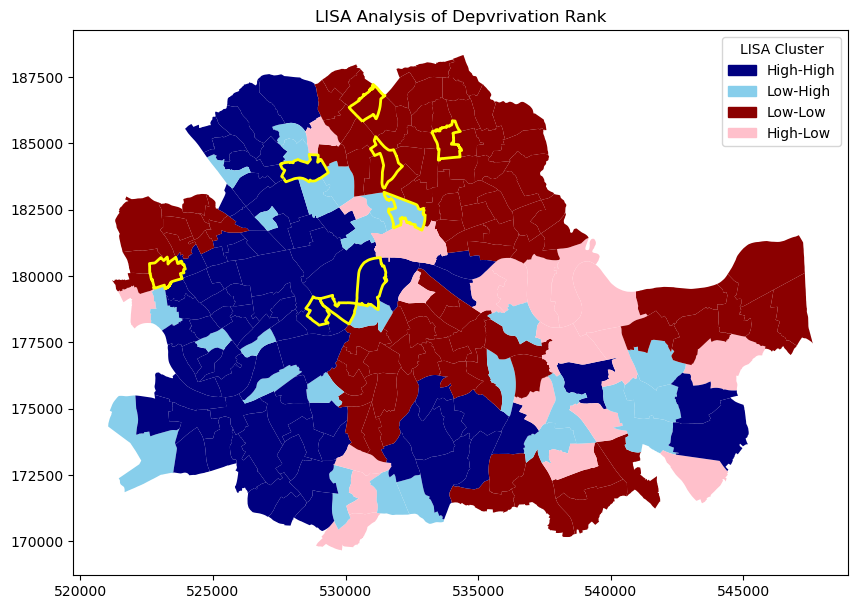

In [153]:
## Inner London LISA Analysis: Deprivation

# List of Inner London Boroughs
inner_london_boroughs = [
    'Camden', 'Greenwich', 'Hackney', 'Hammersmith and Fulham', 'Islington', 
    'Kensington and Chelsea', 'Lambeth', 'Lewisham', 'Southwark', 'Tower Hamlets', 
    'Wandsworth', 'Westminster', 'City of London'
]

# Extract the borough name from 'Ward name'
ward_airbnb['borough'] = ward_airbnb['Ward name'].str.split(' - ').str[0]

# Filter the dataset to include only inner London boroughs
inner_london_wards = ward_airbnb[ward_airbnb['borough'].isin(inner_london_boroughs)]

# Create a spatial weights matrix based on Queen contiguity
w = Queen.from_dataframe(inner_london_wards, use_index=False)

# Ensure the weights are row-standardized
w.transform = 'r'

# Use the vulnerability variable for LISA analysis
y = inner_london_wards['(ID2010) - Rank of average score (within London) - 2010'].values

# Calculate Local Moran's I
lisa = Moran_Local(y, w)

# Add the LISA statistics to the GeoDataFrame
inner_london_wards['moran_local'] = lisa.Is
inner_london_wards['p_value'] = lisa.p_sim
inner_london_wards['quadrant'] = lisa.q

# Identify significant clusters at 0.05 level
inner_london_wards['significant'] = inner_london_wards['p_value'] < 0.05

# Define custom colormap for the LISA quadrants
custom_cmap = ListedColormap(['navy', 'skyblue', 'darkred', 'pink'])  # Soft dark red, soft light blue, soft dark blue, soft light red

# Plot the LISA results
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Use 'quadrant' for the categorical color mapping
inner_london_wards.plot(
    column='quadrant',  # Use 'quadrant' for discrete categories
    cmap=custom_cmap,    # Apply the custom colormap
    ax=ax,
    legend=False         # Disable the color bar
)

# Outline the wards with 'at_risk' status
at_risk_wards = inner_london_wards[inner_london_wards['status'] == 'at_risk']
at_risk_wards.plot(
    edgecolor='yellow',    # Set black boundary for at-risk wards
    linewidth=2,          # Thicker line width for visibility
    ax=ax,
    facecolor='none'      # No fill color, just outlines
)

# Manually create legend with cluster labels
legend_labels = ['High-High', 'Low-High', 'Low-Low', 'High-Low']
colors = custom_cmap(range(4))  # Get colors from the custom colormap

# Add the custom legend to the plot
legend_elements = [Patch(color=colors[i], label=legend_labels[i]) for i in range(4)]
ax.legend(handles=legend_elements, title='LISA Cluster')

plt.title('LISA Analysis of Depvrivation Rank')
plt.show()

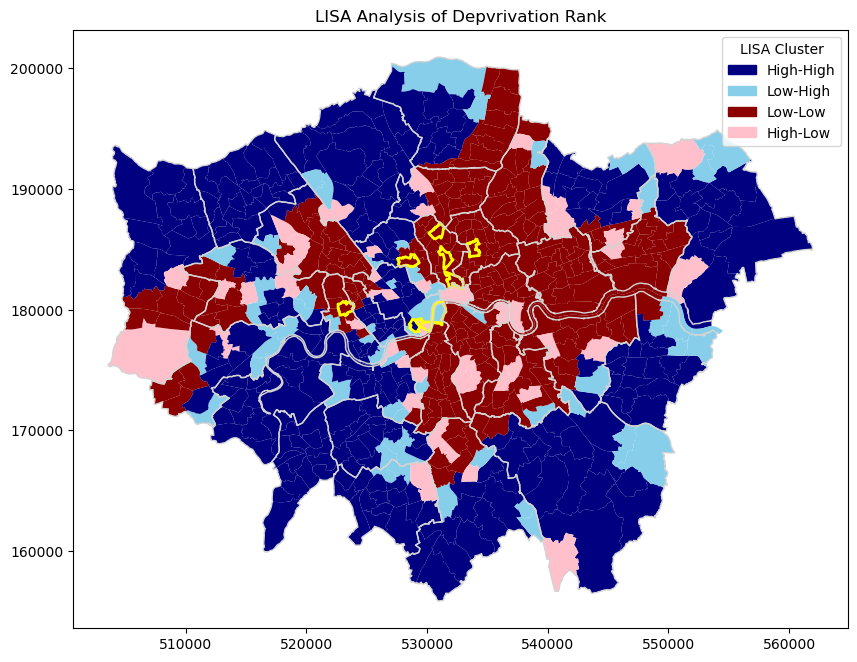

In [189]:
## All London LISA Analysis: Deprivation

# Create a spatial weights matrix based on Queen contiguity
w = Queen.from_dataframe(ward_airbnb, use_index=False)

# Ensure the weights are row-standardized
w.transform = 'r'

# Use the vulnerability variable for LISA analysis
y = ward_airbnb['(ID2010) - Rank of average score (within London) - 2010'].values

# Calculate Local Moran's I
lisa = Moran_Local(y, w)

# Add the LISA statistics to the GeoDataFrame
ward_airbnb['moran_local'] = lisa.Is
ward_airbnb['p_value'] = lisa.p_sim
ward_airbnb['quadrant'] = lisa.q

# Identify significant clusters at 0.05 level
ward_airbnb['significant'] = inner_london_wards['p_value'] < 0.05

# Define custom colormap for the LISA quadrants
custom_cmap = ListedColormap(['navy', 'skyblue', 'darkred', 'pink'])  # Soft dark red, soft light blue, soft dark blue, soft light red

# Plot the LISA results
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Use 'quadrant' for the categorical color mapping
ward_airbnb.plot(
    column='quadrant',  # Use 'quadrant' for discrete categories
    cmap=custom_cmap,    # Apply the custom colormap
    ax=ax,
    legend=False         # Disable the color bar
)

# Outline the wards with 'at_risk' status
at_risk_wards = ward_airbnb[ward_airbnb['status'] == 'at_risk']
at_risk_wards.plot(
    edgecolor='yellow',    # Set black boundary for at-risk wards
    linewidth=2,          # Thicker line width for visibility
    ax=ax,
    facecolor='none'      # No fill color, just outlines
)

# Outline the wards with 'at_risk' status
boroughs.plot(
    edgecolor='lightgrey',    # Set black boundary for at-risk wards
    linewidth=1,          # Thicker line width for visibility
    ax=ax,
    facecolor='none'      # No fill color, just outlines
)

# Manually create legend with cluster labels
legend_labels = ['High-High', 'Low-High', 'Low-Low', 'High-Low']
colors = custom_cmap(range(4))  # Get colors from the custom colormap

# Add the custom legend to the plot
legend_elements = [Patch(color=colors[i], label=legend_labels[i]) for i in range(4)]
ax.legend(handles=legend_elements, title='LISA Cluster')

plt.title('LISA Analysis of Depvrivation Rank')
plt.show()